In [1]:
# !wget -O train.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/train.tar.gz?download=true
# !wget -O test.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/test.tar.gz?download=true
# !wget -O validation.tar.gz -q https://huggingface.co/datasets/project-sloth/captcha-images/resolve/main/data/validation.tar.gz?download=true

In [2]:
# !gunzip *.tar.gz --force
# ! cat *.tar | tar -xf - -i
# !mkdir data
# !!mv test/ data/
# !mv train/ data/
# !mv validation/ data/

In [3]:
import silence_tensorflow.auto
import tensorflow as tf
gpuDevices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpuDevices))
tf.config.experimental.set_memory_growth(gpuDevices[0], True)
tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.disable_eager_execution()
import keras
import os, sys, random, glob, time, logging, io
from PIL import Image

from IPython import display
import matplotlib.pyplot as plt
import numpy as np

Num GPUs Available:  1


In [4]:
batch_size = 32
image_shape = (50,200,1)

In [5]:
# @tf.function
def get_shape(ds:tf.data.Dataset):
    for image, label in ds.unbatch().take(1):
        tf.print("image:")
        tf.print(tf.shape(image))
        tf.print(image.dtype)
        tf.print("label:")
        tf.print(tf.shape(label))
        tf.print(label.dtype)
        # print("Single label:", label.numpy())

# @tf.function
def decode_one_hot(one_hot_label: tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [6, 10])
    digits = tf.argmax(one_hot_reshaped, axis=-1)
    return tf.strings.reduce_join(tf.strings.as_string(digits), axis=0)
    

# @tf.function
def decode_one_hot_2dim(one_hot_label : tf.Tensor) ->  tf.Tensor:
    one_hot_reshaped = tf.reshape(one_hot_label, [6, 10])
    return tf.argmax(one_hot_reshaped, axis=1)


def viz_ds(ds:tf.data.Dataset, count=6):
    plt.figure()
    ds= ds.unbatch().take(count)
    dsit = iter(ds)
    for i in range(count):
        image, label  = next(dsit)  # type: ignore
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"),cmap="gray")
        if (len(label.numpy().shape) == 2):
             plt.title(decode_one_hot_2dim(label).numpy())
        else:
            plt.title(label.numpy())
            
        plt.tight_layout()
        plt.axis("off")

In [6]:
# @tf.function
def get_label(file_path: tf.Tensor):
  # print(file_pathx)
  parts = tf.strings.split(file_path, os.path.sep)
  # print(split(parts[-1], ".")[0])
  return tf.strings.split(parts[-1], ".")[0]

In [7]:
# # @tf.function
# def label_to_one_hot(label:tf.Tensor) -> tf.Tensor:
#     digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
#     one_hot_digits = tf.one_hot(digits, depth=10)
#     one_hot_label = tf.reshape(one_hot_digits, [-1])
#     return one_hot_label

# @tf.function
def label_to_one_hot_2d(label:tf.Tensor) -> tf.Tensor:
    digits = tf.strings.to_number(tf.strings.unicode_split(label, 'UTF-8'), out_type=tf.int32)
    one_hot_digits = tf.one_hot(digits, depth=10)
    return one_hot_digits


# Unit test:
test_label = tf.constant("123456", dtype=tf.string)
one_hot_result = label_to_one_hot_2d(test_label)
print(one_hot_result.numpy())
print(one_hot_result.numpy().shape)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(6, 10)


In [8]:
# @tf.function
def decode_img(img: tf.Tensor) -> tf.Tensor:
  return tf.io.decode_image(img,channels=1, dtype=tf.float32, expand_animations = False) # type: ignore

# @tf.function
def preprocess_image(image:tf.Tensor) -> tf.Tensor:
  # tf.print(tf.shape(image))
  image = tf.image.resize(image, (50,200))
  image = tf.image.per_image_standardization(image)
  return image

# @tf.function
def preprocess_label(label : tf.Tensor) -> tf.Tensor:
  return label_to_one_hot_2d(label)

In [9]:
# @tf.function
def configure_for_performance(ds:tf.data.Dataset) -> tf.data.Dataset:
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [10]:
# @tf.function
def process_path(file_path:tf.Tensor) -> tuple[tf.Tensor,tf.Tensor]:
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return preprocess_image(img), preprocess_label(label)

In [22]:
def create_dataset(folderName: str) -> tf.data.Dataset :
    ds = tf.data.Dataset.list_files(f"./data/{folderName}/*.jpg", shuffle=False)
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds)
    print(ds.cardinality().numpy())
    viz_ds(ds)
    return ds

188
63


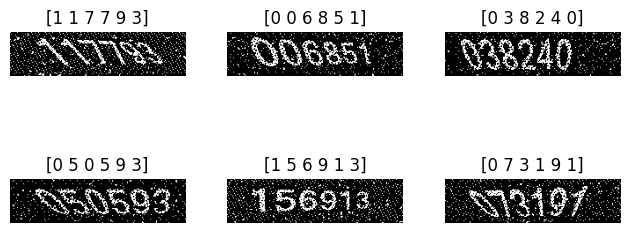

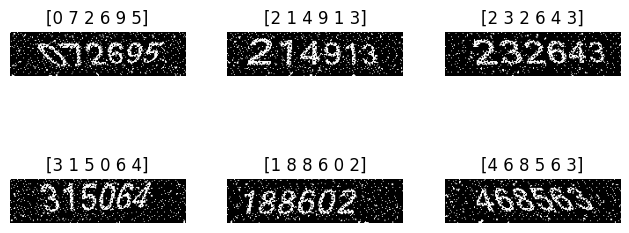

In [24]:
train_ds = create_dataset("train")
test_ds = create_dataset("test")

In [12]:
loss_fn = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
train_loss = keras.metrics.Mean(name='train_loss')
train_acc_metric = keras.metrics.CategoricalAccuracy(name='train_accuracy')


In [13]:
def make_encoder() :
    input_layer = keras.layers.Input(shape=(50,200,1))
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    
    x = keras.layers.Flatten(name='flatten_after_convs')(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)

    output_layer = keras.layers.Dense(6 * 10, activation='softmax')(x)
    output_layer = keras.layers.Reshape((6, 10), name='final_reshape')(output_layer)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()
    
    return model
        

model = make_encoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 200, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_after_convs (Flatten)   │ (None, 19200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,830,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        30,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_reshape (Reshape)         │ (None, 6, 10)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,954,364 (37.97 MB)

 Trainable params: 9,954,364 (37.97 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print(model.input_shape)
print(model.output_shape)
print(model.dtype)
input, target = next(iter(train_ds.take(1)))
print(input.shape)
print(target.shape)
print(target.dtype)


(None, 50, 200, 1)
(None, 6, 10)
float32
(32, 50, 200, 1)
(32, 6, 10)
<dtype: 'float32'>


In [15]:
def create_dummy_dataset(num_samples=1000):
    images = tf.random.normal(shape=(num_samples, 50, 200, 1))
    labels = tf.random.uniform(shape=(num_samples, 6), minval=0, maxval=10, dtype=tf.int32)
    labels_one_hot = tf.one_hot(labels, depth=10)
    
    return images, labels_one_hot

num_samples = 1000
images, labels = create_dummy_dataset(num_samples)

dummy_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dummy_dataset = dummy_dataset.shuffle(buffer_size=num_samples).batch(batch_size)

In [16]:
# get_shape(dummy_dataset)
get_shape(train_ds)
# get_shape(train_ds.take(1))
# viz_ds(dummy_dataset)

image:
[50 200 1]
tf.float32
label:
[6 10]
tf.float32


In [19]:
# tf.config.run_functions_eagerly(False)
# tf.debugging.set_log_device_placement(True)
model.fit(train_ds, epochs=30)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8353 - loss: 0.4545
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8477 - loss: 0.4288
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8559 - loss: 0.4020
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8627 - loss: 0.3752
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8705 - loss: 0.3589
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8778 - loss: 0.3366
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8830 - loss: 0.3213
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8911 - loss: 0.3054
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8905 - loss: 0.3011
Epoch 10/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8955 - loss: 0.2873
Epoch 11/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8965 - loss: 0.2810
Epoch 12/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
def evaluate_model_visual(model, test_dataset:tf.data.Dataset):
    loss, accuracy = model.evaluate(test_dataset)
    
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")
    for images, labels in test_dataset.take(1):
        predictions = model.predict(images)
        
        plt.figure(figsize=(12, 8))  # Adjust figure size for better display
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = tf.nn.softmax(predictions[i]).numpy()
            
            # Get predicted and true label indices
            pred_label_indices = np.argmax(pred_label, axis=-1)
            true_label_indices = np.argmax(true_label, axis=-1)
            
            # Subplot with 3 images per row
            plt.subplot(len(images) // 3 + 1, 3, i + 1)
            plt.imshow(images[i].numpy().reshape(50, 200), cmap='gray')
            plt.title(f"True: {true_label_indices}, Pred: {pred_label_indices}")
            plt.axis('off')  # Hide axes for better visualization
        
        plt.tight_layout()
        plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9560 - loss: 0.1464
Test Loss: 0.16995109617710114
Test Accuracy: 0.9507501721382141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


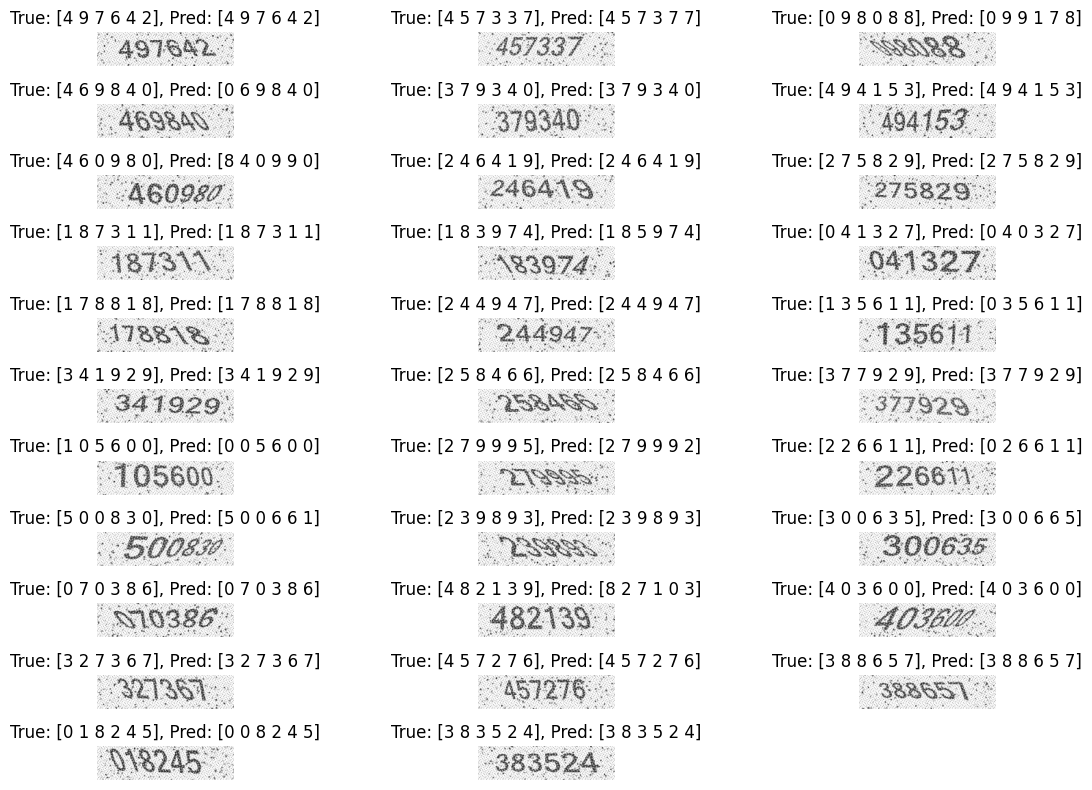

In [33]:
evaluate_model_visual(model, test_ds)